In [1]:
import numpy as np
from numpy import log, sqrt, sin, cos, exp, pi, prod
from numpy.random import normal, uniform

In [2]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [3]:
import scipy.stats
from tqdm import tqdm

In [4]:
from tools import HelperTorch
from domain import Flower, Polygon, Heart, Cross, Star

In [5]:
import torch

In [6]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.random.seed(9)

In [7]:
class Sampler:
    def __init__(self, myHelper, device='cpu', boundary=None, xinit=None, lr=0.1, T=1.0, seed=1):
        self.lr = lr
        self.T = T
        self.myHelper = myHelper
        self.device = device
        self.x = torch.Tensor(xinit).to(self.device)
        self.list = torch.empty((2, 0)).to(self.device)
        
        self.unreflected_x = torch.Tensor(np.array(xinit) + np.array([0., 0.03])).to(self.device)
        self.unreflected_list = torch.empty((2, 0)).to(self.device)
        np.random.seed(mySeed)
        torch.manual_seed(mySeed)
        torch.cuda.manual_seed(mySeed)
    def reflection(self, prev_beta, beta):
        if self.myHelper.inside_domain(beta):
            return beta
        else:
            reflected_points, boundary = self.myHelper.get_reflection(prev_beta, beta)
            """ numerical discretization may fail to reflect in extreme cases """
            if not self.myHelper.inside_domain(reflected_points):
                reflected_points = boundary
            
            return reflected_points

    
    def rgld_step(self, iters):  
        if self.device.startswith('cuda'):
            noise = torch.cuda.FloatTensor(2).normal_().mul(sqrt(2. * self.lr * self.T))
        else:
            noise = torch.normal(mean=0., std=1., size=[2]) * sqrt(2. * self.lr * self.T)
        proposal = self.x - self.lr * self.x + noise
        self.x = self.reflection(self.x, proposal)
        
        self.unreflected_x = self.unreflected_x - self.lr * self.unreflected_x + noise
        
        if iters % 50 == 0:
            self.list = np.concatenate((self.list, \
                                        self.x.reshape(-1, 1)), axis=1)
            
            self.unreflected_list = np.concatenate((self.unreflected_list, \
                                        self.unreflected_x.reshape(-1, 1)), axis=1)


In [8]:
def plot_domain(myDomainClass):
    points = myDomainClass.position(np.arange(0, 1, 0.001))
    fig = plt.figure(figsize=(3, 3))
    plt.plot(points[0, :], points[1, :])
    plt.legend(loc="upper left", prop={'size': 10})
    plt.tight_layout()
    plt.show()

In [9]:
def plot_MCMC_traj(myHelper, myDomainClass, iters=1e5, lr=1e-4, xinit=[0., 0.], boundary_=1.5, fname='unknown', seed=1):
    sampler = Sampler(myHelper, boundary=boundary_, xinit=xinit, lr=lr, T=2, seed=seed)
    boundary = myDomainClass.position(np.arange(0, 1, 0.001))
    for iters in tqdm(range(int(iters))):
        sampler.rgld_step(iters)
    fig = plt.figure(figsize=(4, 4))
    plt.plot(sampler.list[0, :], sampler.list[1, :], \
             linewidth=0.7, marker='.', markersize=0.5, color='indianred') 
    
    plt.plot(sampler.unreflected_list[0, :], sampler.unreflected_list[1, :], \
             linewidth=0.7, marker='.', markersize=0.5, color='lightseagreen') 
    plt.legend(loc="upper left", prop={'size': 10})
    plt.plot(boundary[0, :], boundary[1, :], color='grey')
    plt.xlim([-boundary_, boundary_])
    plt.ylim([-boundary_, boundary_])
    plt.tight_layout()
    plt.axis('off')
    plt.savefig(f"./results/{fname}.pdf", format="pdf", bbox_inches="tight", dpi=500)
    plt.show()

No handles with labels found to put in legend.


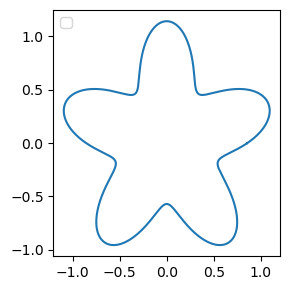

In [44]:
myFlower = Flower(petals=5, move_out=3)
plot_domain(myFlower)

In [45]:
myHelper = HelperTorch(Flower, grid_radius=1e-2, grid_curve=1e-3)

100%|██████████| 100000/100000 [00:15<00:00, 6257.87it/s]
No handles with labels found to put in legend.


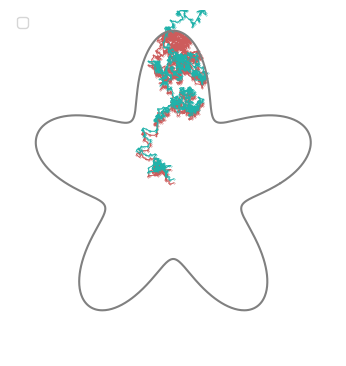

In [46]:
mySeed = 2720
plot_MCMC_traj(myHelper, myFlower, iters=1e5, lr=1e-6, xinit=[0, 0], boundary_=1.3, fname='flower', seed=mySeed)

No handles with labels found to put in legend.


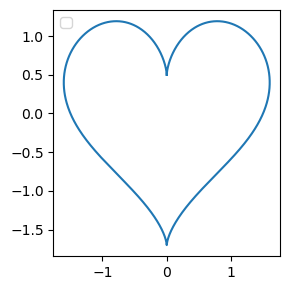

In [47]:
myHeart = Heart()
plot_domain(myHeart)

In [48]:
myHelper = HelperTorch(Heart, grid_radius=3e-3, grid_curve=3e-4)

100%|██████████| 100000/100000 [04:12<00:00, 396.02it/s]
No handles with labels found to put in legend.


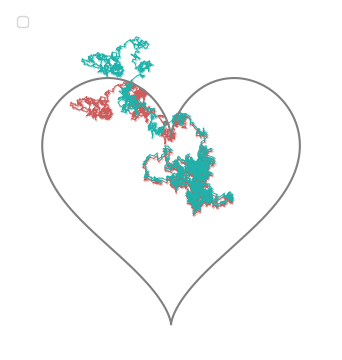

In [49]:
mySeed = 9075
plot_MCMC_traj(myHelper, myHeart, iters=1e5, lr=3e-6, boundary_=2, fname='heart', seed=mySeed)

No handles with labels found to put in legend.


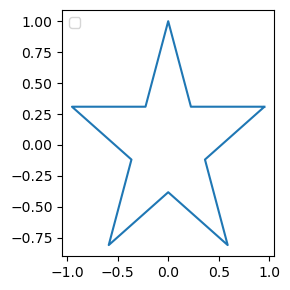

In [50]:
myStar = Star()
plot_domain(myStar)

In [56]:
myHelper = HelperTorch(Star, grid_radius=2e-3, grid_curve=2e-4)

100%|██████████| 100000/100000 [11:26<00:00, 145.64it/s]
No handles with labels found to put in legend.


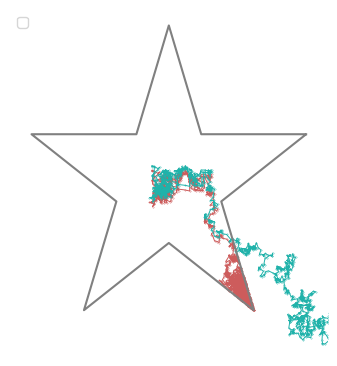

In [57]:
mySeed = 2184
plot_MCMC_traj(myHelper, myStar, iters=1e5, lr=1e-6, boundary_=1.1, fname='star', seed=mySeed)

No handles with labels found to put in legend.


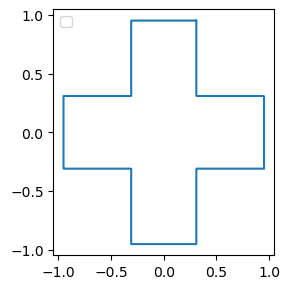

100%|██████████| 100000/100000 [15:36<00:00, 106.80it/s]
No handles with labels found to put in legend.


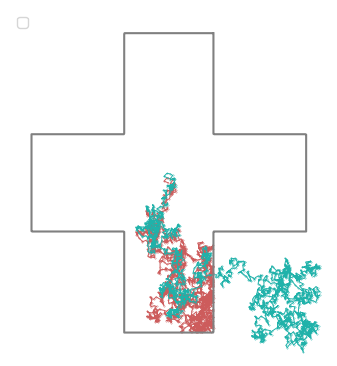

In [62]:
myCross = Cross()
plot_domain(myCross)
myHelper = HelperTorch(Cross, grid_radius=1e-3, grid_curve=3e-4)

    
mySeed = 9644
mySeed = 1888
plot_MCMC_traj(myHelper, myCross, iters=1e5, lr=1e-6, boundary_=1.1, fname='cross', seed=mySeed)

No handles with labels found to put in legend.


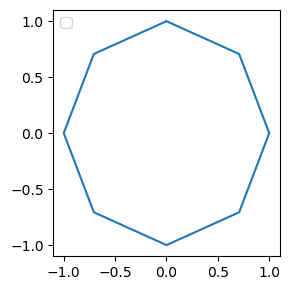

100%|██████████| 100000/100000 [00:12<00:00, 7885.72it/s]
No handles with labels found to put in legend.


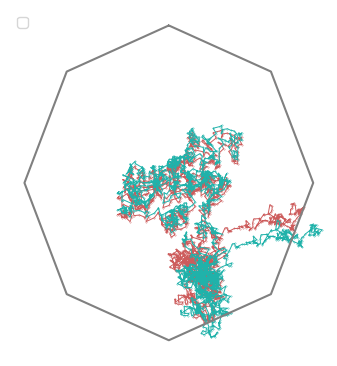

In [12]:
myPolygon = Polygon(corners=8)
plot_domain(myPolygon)
myHelper = HelperTorch(Polygon)
mySeed = 1336
plot_MCMC_traj(myHelper, myPolygon, iters=1e5, lr=2e-6, boundary_=1.1, fname='polygon', seed=mySeed)